### importing libraries

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [2]:
df = pd.read_csv("./data/combined_with_who.csv")

In [3]:
df.head()

,label,text
0,true,US coronavirus vaccine trial on hold after UK ...
1,true,Penn State Reports 320 Cases Of Coronavirus On...
2,true,Chinese mainland reports 10 new COVID-19 cases...
3,true,Mask resistance during a pandemic isn't new – ...
4,true,U.S. adults experienced increased mental healt...


In [4]:
df.shape

(9974, 2)

In [5]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [6]:
df.dtypes

label    object
text     object
dtype: object

In [7]:
df['label'].value_counts()

false         6315
true          2500
misleading    1159
Name: label, dtype: int64

In [8]:
df.describe()

,label,text
count,9974,9974
unique,3,9974
top,false,"Photo of an Indonesian doctor, Hideo Ali, loo..."
freq,6315,1


taking a look at what are the most used words

In [9]:
cv = CountVectorizer(stop_words='english')
cv.fit(df['text'])

text_cv = cv.transform(df['text'])
text_df = pd.DataFrame(text_cv.todense(), columns=cv.get_feature_names())

print(text_df.shape)
text_df.sum().sort_values(ascending=False).head(20)

(9974, 13265)


coronavirus    3680
covid          3306
19             3102
people          863
video           823
new             683
shows           602
pandemic        570
lockdown        520
cases           509
vaccine         504
india           469
china           464
government      413
virus           404
says            400
facebook        397
president       360
health          355
novel           353
dtype: int64

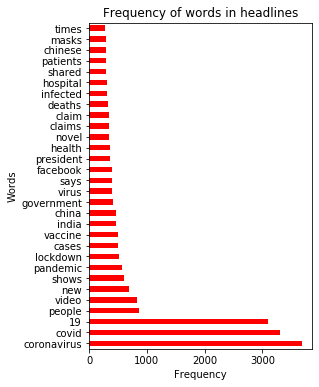

In [10]:
plt.figure(figsize=(4,6))
text_df.sum().sort_values(ascending=False).head(30).plot(kind='barh',color= 'red')
plt.title('Frequency of words in headlines')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.savefig("./assets/word-freq-in-headlines.png");

Waht about using regex tokenizer?

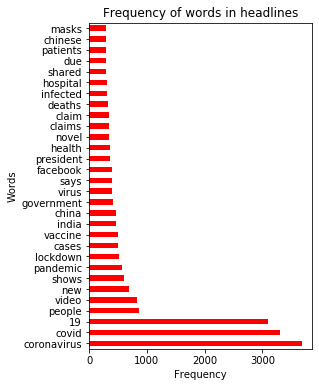

In [15]:
tokenizer = RegexpTokenizer(r'\w+')

hold_list = []
for words in df['text']:
    sing_word = tokenizer.tokenize(words.lower())
    hold_list.append(sing_word)

single_list = [i for token in hold_list for i in token]

stopless_list = [token for token in single_list if token not in stopwords.words('english')]


plt.figure(figsize=(4,6))
word_comp = pd.DataFrame(stopless_list)
word_comp.rename(columns = {0 : 'words'}, inplace=True)
word_comp['words'].value_counts().head(30).plot(kind='barh', color= 'red')
plt.title('Frequency of words in headlines')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.savefig("./assets/word-freq-in-headlines-reg-tok.png");

Same as above; only exclusively for true target

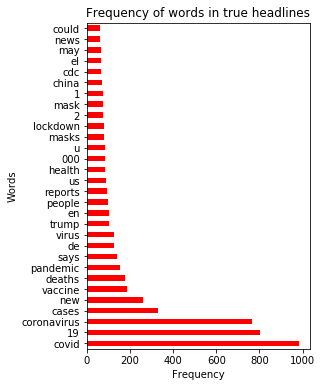

In [16]:
true_df = df[df['label'] == 'true']

hold_list = []
for words in true_df['text']:
    sing_word = tokenizer.tokenize(words.lower())
    hold_list.append(sing_word)

single_list = [i for token in hold_list for i in token]

stopless_list = [token for token in single_list if token not in stopwords.words('english')]

plt.figure(figsize=(4,6))
word_comp = pd.DataFrame(stopless_list)
word_comp.rename(columns = {0 : 'words'}, inplace=True)
word_comp['words'].value_counts().head(30).plot(kind='barh', color= 'red')
plt.title('Frequency of words in true headlines')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.savefig("./assets/word-freq-in-true-headlines-regtok.png");

## let's do a Sentiment Analysis using a list of words we created

In [17]:
positive_words = ['brave','great', 'improve',
                  'amazing','decrease','strong','safe', 'clean',
                  'happy','love', 'enjoy','accomplish','achieve',
                  'good', 'negative', 'cure', 'support','effective','save', 'open']
negative_words = ['infected','violence','terrible','worse','death','fake', 'illegal',
                  'destroy', 'aggresive','enemy','crash',
                  'bad','false','rude','disappointed','positive','crisis','increase']

In [18]:
def pos_sentiment(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(word) for word in tokens]
    positive_stems = [p_stemmer.stem(word) for word in positive_words]
    return sum([1 for i in stemmed_words if i in positive_stems])/ len(stemmed_words)

In [19]:
def neg_sentiment(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(word) for word in tokens]
    negative_stems = [p_stemmer.stem(word) for word in negative_words]
    return sum([1 for i in stemmed_words if i in negative_stems])/ len(stemmed_words)

In [20]:
pos = []
neg = []
for post in df['text']:
    pos_scores = pos_sentiment(post)
    neg_scores = neg_sentiment(post)
    pos.append(pos_scores)
    neg.append(neg_scores)

In [21]:
sentiment = pd.DataFrame({'pos': pos, 'neg': neg})

In [22]:
sentiment_df = pd.concat([df, sentiment], axis=1)

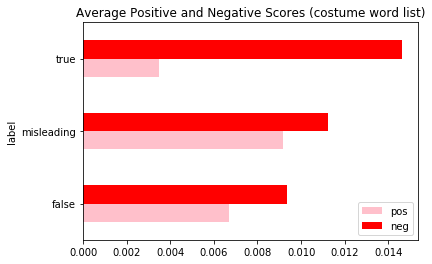

In [24]:
sentiment_df.groupby('label').mean()[['pos', 'neg']].plot(kind = 'barh', color=('pink','red'))
plt.title('Average Positive and Negative Scores (costume word list)')
plt.savefig("./assets/avg-pos-neg-cost-list.png");

true posts, seem to be very negative, and have the least possitive words, which means when it comes to pandemics, we obvisly are not haveing a grand ol' time

## let's take a look at a Sia- Polarities with VADER

In [25]:
sia = SentimentIntensityAnalyzer()

dicts = []

for title in df['text']:
    scores = sia.polarity_scores(title)
    dicts.append(scores)
    
scores = pd.DataFrame(dicts)
scores.describe()

,neg,neu,pos,compound
count,9974.000000,9974.000000,9974.000000,9974.000000
mean,0.082997,0.858382,0.058518,-0.061524
std,0.121890,0.144465,0.099296,0.364053
min,0.000000,0.000000,0.000000,-0.952300
25%,0.000000,0.760000,0.000000,-0.318200
50%,0.000000,0.872000,0.000000,0.000000
75%,0.158000,1.000000,0.105000,0.025800
max,0.744000,1.000000,0.778000,0.940300


In [26]:
sia_df = pd.concat([df, scores], axis = 1)

In [27]:
sia_df.sort_values(by = 'neg', ascending = False).head(10)

,label,text,neg,neu,pos,compound
126,true,Lockdown Woes,0.744,0.256,0.0,-0.4404
2202,true,Every COVID-19 Death Has Devastated a Family,0.664,0.336,0.0,-0.8360
6743,false,COVID-19 is a hoax or scapegoat for economic ...,0.640,0.360,0.0,-0.8360
2624,false,Infrared thermometers kill neurons.,0.610,0.390,0.0,-0.6908
9442,misleading,China killed pigs over fear of coronavirus.,0.606,0.394,0.0,-0.8271
9257,false,Coronavirus is a biological warfare weapon.,0.595,0.405,0.0,-0.5267
8986,false,Disinfectant gel causes cancer.,0.595,0.405,0.0,-0.6597
939,true,Overwhelming Racism of CoronavirusCoverage,0.577,0.423,0.0,-0.6249
2384,true,Hundreds of violent attacks on NHS ambulance w...,0.577,0.423,0.0,-0.8979
1991,true,The Other Way Covid Will Kill: Hunger,0.573,0.427,0.0,-0.7717


In [28]:
sia_df.sort_values(by = 'pos', ascending = False).head(10)

,label,text,neg,neu,pos,compound
8922,false,Vitamin C prevents coronavirus.,0.0,0.222,0.778,0.3612
9062,misleading,Vitamin helps against COVID-19.,0.0,0.294,0.706,0.5859
1657,true,Protect Your Health with Immune Defence,0.0,0.326,0.674,0.6369
1216,true,Free Support Groups for Covid-19,0.0,0.333,0.667,0.7184
8503,misleading,Sex helps prevent coronavirus.,0.0,0.351,0.649,0.4019
1924,true,Lucky We Didn't Panic | Self-Evident,0.0,0.353,0.647,0.6707
3921,false,Lacoteferrin prevents and helps prevent coron...,0.0,0.375,0.625,0.4588
8881,false,Vitamin C is a miracle cure for the novel cor...,0.0,0.376,0.624,0.8074
5270,false,Alkaline foods help prevent or treat COVID-19.,0.0,0.381,0.619,0.6705
3793,misleading,Vitamin D helps against the coronavirus.,0.0,0.385,0.615,0.5859


In [29]:
sia_df.sort_values(by = 'compound', ascending = False).head(10)

,label,text,neg,neu,pos,compound
575,true,Biglaw Firm Spreads The Love With COVID Bonuse...,0.000,0.488,0.512,0.9403
4560,false,"Multiple posts on Facebook, Twitter and on va...",0.000,0.802,0.198,0.9360
4186,misleading,"“A shift in world politics, published a dossi...",0.000,0.739,0.261,0.9245
7391,misleading,A WhatsApp forward has gone viral which claim...,0.018,0.856,0.126,0.9178
7486,misleading,A WhatsApp forward claimed that a vaccine for...,0.019,0.848,0.133,0.9178
5940,false,Post in Lithuanian saying: “I don’t protect. ...,0.000,0.811,0.189,0.9151
552,true,"Located in Westchester + NYC, Mercy College sh...",0.044,0.652,0.304,0.9100
9602,false,Chlorine dioxide kits sold online under vario...,0.000,0.596,0.404,0.9042
6538,false,Thousands of Facebook users in the United Sta...,0.000,0.665,0.335,0.9022
3083,misleading,The image of an intubated baby with a large c...,0.000,0.740,0.260,0.8910


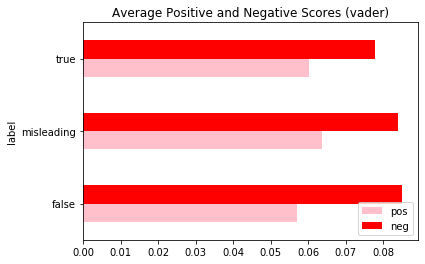

In [30]:
sia_df.groupby('label').mean()[['pos', 'neg']].plot(kind = 'barh', color= ('pink','red'))
plt.title('Average Positive and Negative Scores (vader)')
plt.legend(loc='lower right')
plt.savefig("./assets/avg-pos-neg-vader.png");

intereting that words that sia considers to be negative might actually not be as bad when it comes to a global crisis. since using a sia sentiment analyser we negative posts seem to have just a slight leg to being more negative than using a list of our own. 
true posts seem to a tiny bit more positivity assosiated with them using a sia analyzer

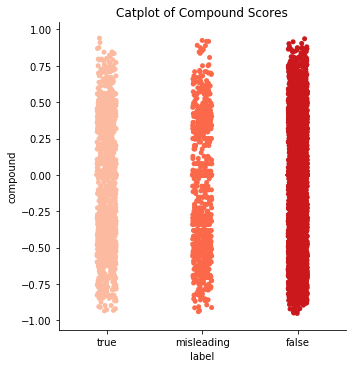

In [31]:
sns.catplot(x = 'label', y = 'compound', data = sia_df, palette="Reds")
plt.title('Catplot of Compound Scores')
plt.savefig("./assets/compound-catplot.png");

- false informations are all over the spectreum, they seem to have the most emothionally drivine, and at the same time neuteral sounding posts, howeve, there seems to be have an ever so slight lapse in neureality 
- misleading information,seem to be mostly either possitive, or negative, with a huge dip in neuterality density., 
- true information, seem to be the most symetric in tone and emotion.

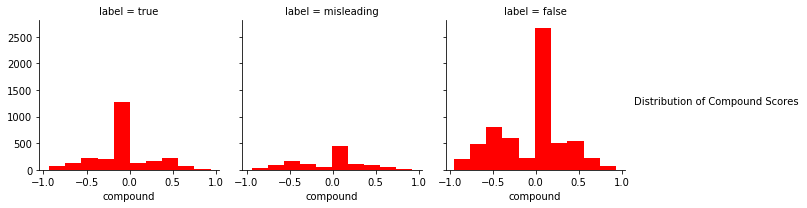

In [32]:
g = sns.FacetGrid(sia_df, col = 'label' )
g.map(plt.hist, 'compound',  color="r" )
g.add_legend(title='Distribution of Compound Scores')
plt.savefig("./assets/compound-dist.png");

- true informations, are not as polorizing, with the majority of the posts being neuteral in tone. the possitive and negative over all scoress seem to not be as polorizing either, as they seem to fall around the midum (-.5,.5)
- in the misleading cathergory, there is a peak at negative tone, and a sharp drop at around neutearl, they seem to have a lot of slightly possitive sounding posts. 
- althoogh the majority of false information are in the ever so slightly possitive information, they seem to be the mosy polorizing, as almost half of the information seem to be at the negative or possitive ends of the spectrum, with an almost hollow point at the slight negative- neuteral scores.

### alright, let's move into modeling next